In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, BertForPreTraining
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)

C:\Users\zoika\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def metrics(y_pred, y_true):
  print("f1 score: ", f1_score(y_true, y_pred))
  print("accuracy: ", accuracy_score(y_true, y_pred))
  print("precision:", precision_score(y_true, y_pred, zero_division=1))
  print("recall: ", recall_score(y_true, y_pred, zero_division=1))

In [3]:
import pandas as pd
path_train = "../../dataset/ari_stop_words_train.csv"
path_test = "../../dataset/ari_stop_words_test.csv"

df = pd.read_csv (path_train)
df_t = pd.read_csv (path_test)
# df = df.drop('Unnamed: 0', axis = 1)
# df_t = df_t.drop('Unnamed: 0', axis = 1)

In [4]:
# df = df.sample(frac=1).reset_index(drop=True)
df_dropped = df.drop('ID', axis=1)
y_train = df['prediction']
x_train = df_dropped.drop('prediction', axis=1)

In [5]:
df_test_dropped = df_t.drop('ID', axis=1)
y_test = df_t['prediction']
x_test = df_test_dropped.drop('prediction', axis=1)

In [6]:
columns = df.columns
for col in columns:
  print(col)
  print(df[col][0])

ID
S082
Difficulties
0.05
uh
1.0
retrace_no_corr
1.0
retrace_with_corr
0.7142857142857143
interruption
0.0
gfi
0.1895494901184684
ari
0.2860418716497606
unique_words
0.0283822138126773
text_len
0.6842105263157895
stop_words
0.5521739130434783
prediction
1


In [7]:
keep_x_train = x_train
keep_x_test = x_test
keep_y_train = y_train
keep_y_test = y_test

## SVM Classifier 

1716503070.4465947
Best parameters found from training data: {'C': 2, 'gamma': 1, 'kernel': 'rbf'}
Best parameters found from test data: {'C': 2, 'gamma': 3, 'kernel': 'poly'}
Best test score: 0.75
-----------------------------------------------train: 
f1 score:  0.819047619047619
accuracy:  0.8240740740740741
precision: 0.8431372549019608
recall:  0.7962962962962963
test: 
f1 score:  0.75
accuracy:  0.7916666666666666
precision: 0.9375
recall:  0.625
Time taken for GridSearchCV: 1.3442528247833252 seconds


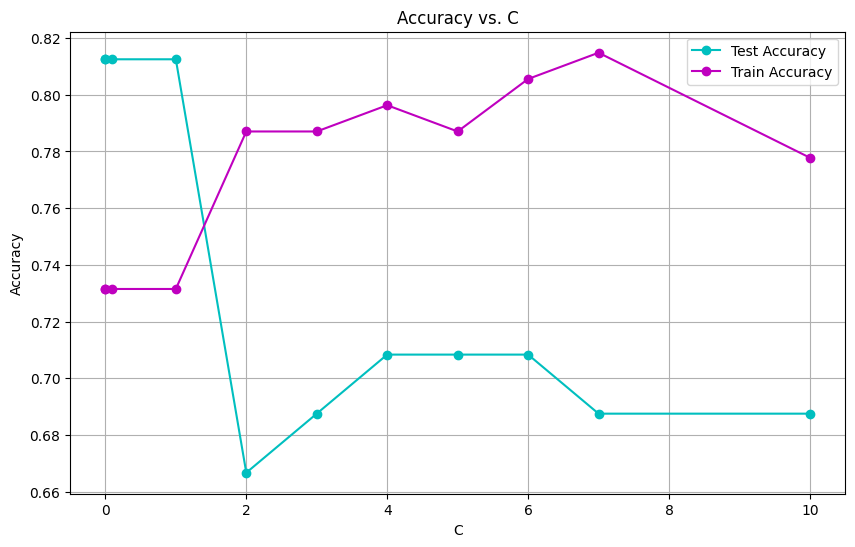

In [53]:
param_grid = {
    'C': [1, 0.1,  0.001, 0.0001, 2, 3, 4, 5, 6, 7, 10],
    'gamma': [1, 0.1,  0.001, 0.0001, 2, 3, 4, 5, 6],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}


model = SVC()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1)

start = time.time()
print(start)
grid_search.fit(x_train, y_train)

end = time.time() - start

print(f"Best parameters found from training data: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_scores = []
train_scores = []
accuracies = []
train_acc=[]
for params in grid_search.cv_results_['params']:
    model = SVC(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    test_score = f1_score(y_test, y_pred)
    train_score = f1_score(y_train, y_pred_train)
    if train_score >= test_score: 
        test_scores.append(test_score)
        train_scores.append(train_score)
    else:
        test_scores.append(0)
        train_scores.append(0)
    if params['gamma'] == 0.1 and params['kernel'] == 'rbf' :
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies.append((params['C'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc.append((params['C'], train_accuracy))


best_index = np.argmax(test_scores)
best_params = grid_search.cv_results_['params'][best_index]
best_test_score = test_scores[best_index]

print(f"Best parameters found from test data: {best_params}")
print(f"Best test score: {best_test_score}")

final_model = SVC(**best_params)
final_model.fit(x_train, y_train)

y_pred_test = final_model.predict(x_test)
y_pred_train = final_model.predict(x_train)

print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)

print(f"Time taken for GridSearchCV: {end} seconds")

accuracies.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies]
accuracy_scores_test = [x[1] for x in accuracies]

train_acc.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc]
accuracy_scores_train = [x[1] for x in train_acc]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. C')
plt.xlabel('C')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()

In [54]:
x_train

,Difficulties,uh,retrace_no_corr,retrace_with_corr,interruption,gfi,ari,unique_words,text_len,stop_words
0,0.050000,1.000000,1.000000,0.714286,0.0,0.189549,0.286042,0.028382,0.684211,0.552174
1,0.129630,0.083333,0.105263,0.285714,0.0,0.178869,0.217468,0.054990,0.368421,0.533981
2,0.000000,0.041667,0.052632,0.071429,0.0,0.131785,0.219169,0.062500,0.368421,0.563636
3,0.035088,0.041667,0.052632,0.214286,0.0,0.124461,0.156496,0.061555,0.526316,0.577586
4,0.070175,0.083333,0.105263,0.357143,0.0,0.089717,0.178634,0.054286,0.526316,0.441176
...,...,...,...,...,...,...,...,...,...,...
103,0.017544,0.041667,0.105263,0.000000,0.0,0.152867,0.228745,0.079832,0.526316,0.487500
104,0.092593,0.000000,0.000000,0.071429,0.0,0.048110,0.135117,0.117647,0.368421,0.510638
105,0.034483,0.291667,0.052632,0.214286,0.0,0.211649,0.366985,0.038334,0.578947,0.584112
106,0.071429,0.000000,0.052632,0.142857,0.0,0.100272,0.176686,0.080925,0.473684,0.523077


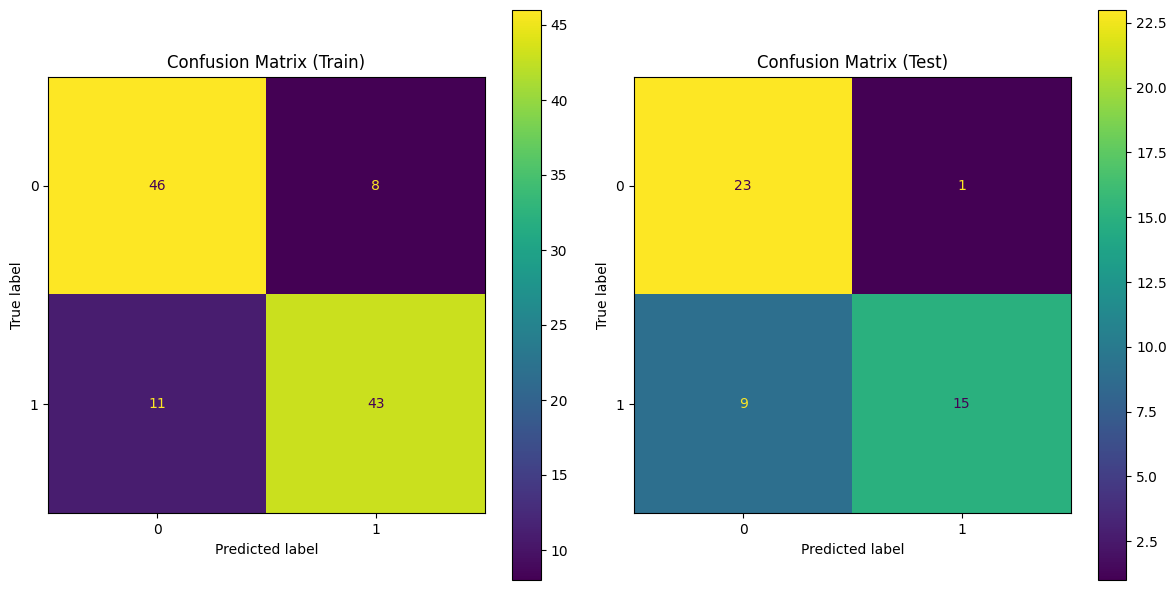

In [58]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

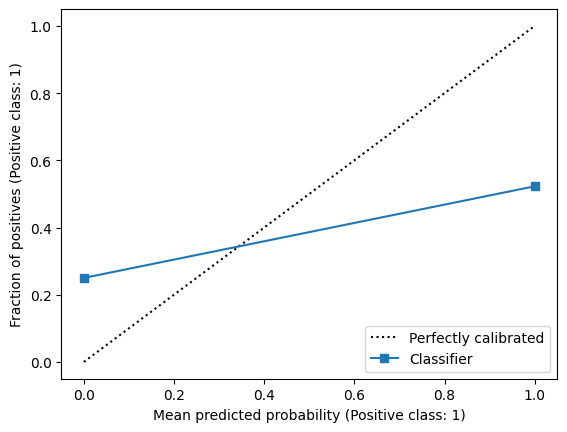

In [59]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred)
plt.show()

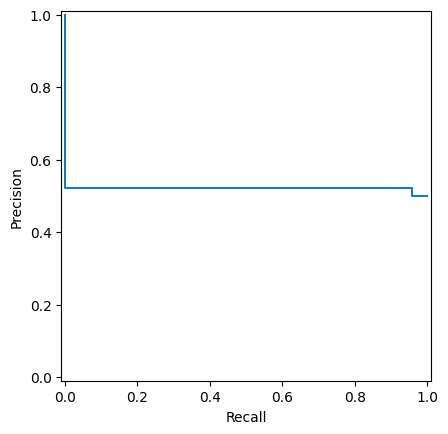

In [60]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## Logistic Regression 

In [13]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 110, 125, 25, 50, 75, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [1000], 
    'random_state':[0]
}

model = LogisticRegression(max_iter=1000)
x_train.drop("unique_words", axis=1)
x_test.drop("unique_words", axis=1)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

start = time.time()

grid_search.fit(x_train, y_train)

end = time.time() - start

print(f"Best parameters found from training data: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_scores = []
accuracies = []
train_acc = []

accuracies_2 = []
train_acc_2 = []
for params in grid_search.cv_results_['params']:
    # model = LogisticRegression(random_state=0, **params)
    model = LogisticRegression(**params)
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    test_score = f1_score(y_test, y_pred)
    test_scores.append(test_score)
    if params['solver'] == 'lbfgs':
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies.append((params['C'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc.append((params['C'], train_accuracy))
    if params['C'] == 50:
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies_2.append((params['solver'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc_2.append((params['solver'], train_accuracy))

best_index = np.argmax(test_scores)
best_params = grid_search.best_params_
best_test_score = test_scores[best_index]

print(f"Best parameters found from test data: {best_params}")
print(f"Best test score: {best_test_score}")

final_model = LogisticRegression( **best_params)
final_model.fit(x_train, y_train)

y_pred_test = final_model.predict(x_test)
y_pred_train = final_model.predict(x_train)

print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)
print(train_acc)
print(f"Time taken for GridSearchCV: {end} seconds")

x_train=keep_x_train
x_test=keep_x_test

Fitting 10 folds for each of 66 candidates, totalling 660 fits
Best parameters found from training data: {'C': 110, 'max_iter': 1000, 'random_state': 0, 'solver': 'lbfgs'}
Best parameters found from test data: {'C': 110, 'max_iter': 1000, 'random_state': 0, 'solver': 'lbfgs'}
Best test score: 0.7804878048780488
-----------------------------------------------train: 
f1 score:  0.8181818181818182
accuracy:  0.8148148148148148
precision: 0.8035714285714286
recall:  0.8333333333333334
test: 
f1 score:  0.717948717948718
accuracy:  0.7708333333333334
precision: 0.9333333333333333
recall:  0.5833333333333334
[(0.001, 0.7407407407407407), (0.01, 0.7407407407407407), (0.1, 0.75), (1, 0.7592592592592593), (10, 0.7962962962962963), (110, 0.8148148148148148), (125, 0.8148148148148148), (25, 0.8055555555555556), (50, 0.7962962962962963), (75, 0.8055555555555556), (100, 0.8055555555555556)]
Time taken for GridSearchCV: 0.36689233779907227 seconds


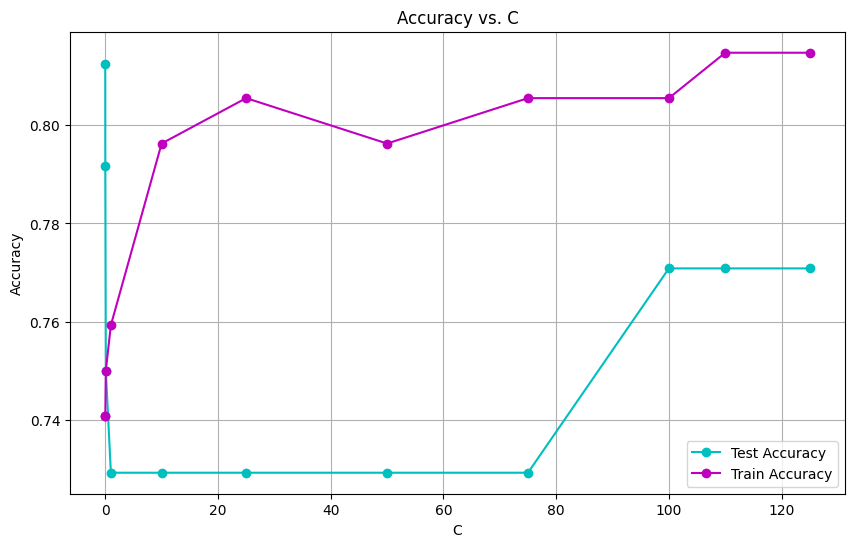

In [14]:
accuracies.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies]
accuracy_scores_test = [x[1] for x in accuracies]

train_acc.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc]
accuracy_scores_train = [x[1] for x in train_acc]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. C')
plt.xlabel('C')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()


[('lbfgs', 0.7291666666666666), ('liblinear', 0.7291666666666666), ('newton-cg', 0.7291666666666666), ('newton-cholesky', 0.7291666666666666), ('sag', 0.7291666666666666), ('saga', 0.7291666666666666)]


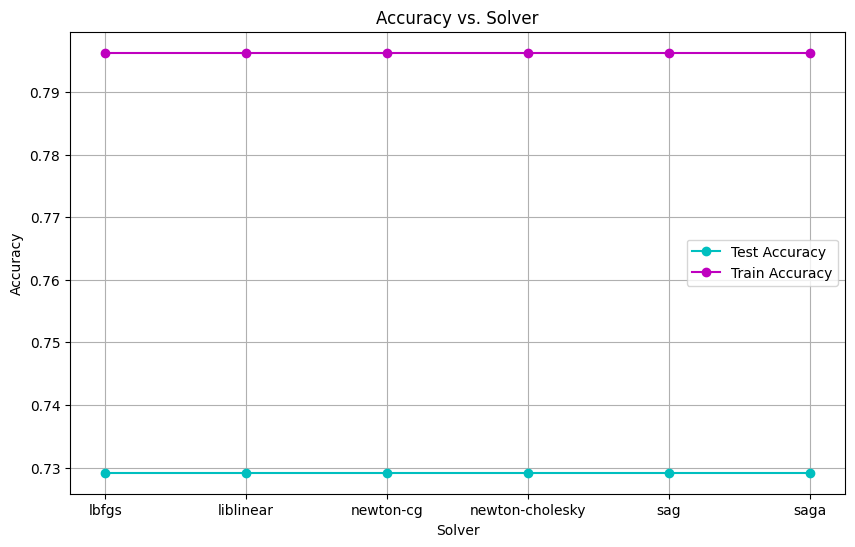

In [15]:
print(accuracies_2)

accuracies_2.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies_2]
accuracy_scores_test = [x[1] for x in accuracies_2]

train_acc_2.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc_2]
accuracy_scores_train = [x[1] for x in train_acc_2]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. Solver')
plt.xlabel('Solver')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()


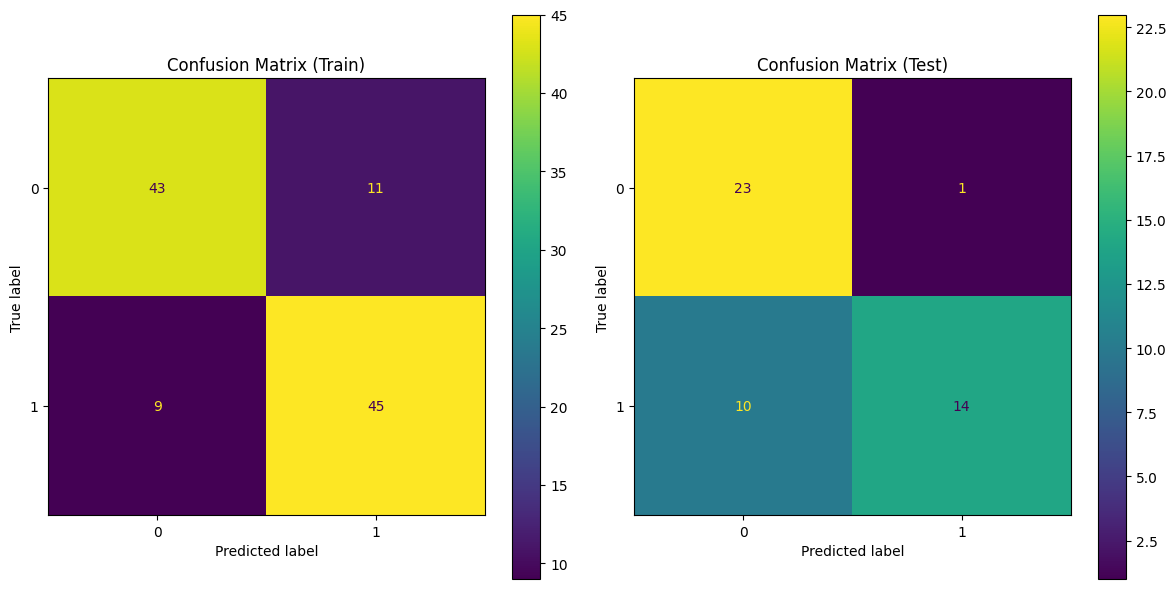

In [16]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

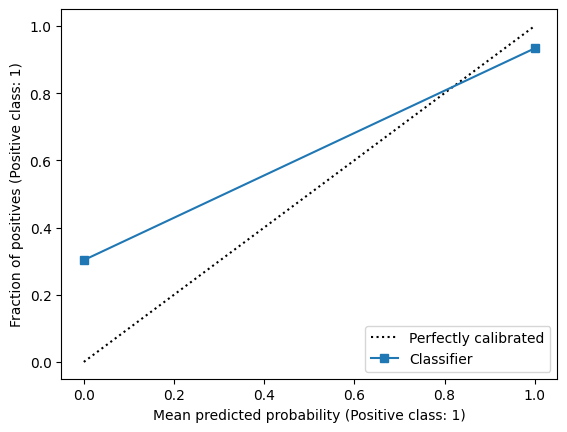

In [17]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred_test)
plt.show()

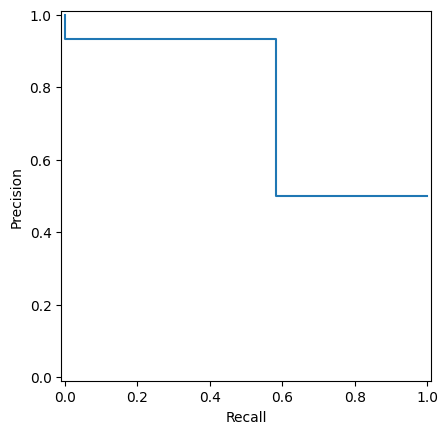

In [18]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## AdaBoost

Fitting 10 folds for each of 28 candidates, totalling 280 fits
Best parameters found from training data: {'algorithm': 'SAMME', 'learning_rate': 0.3, 'n_estimators': 200}
Best parameters found from test data: {'algorithm': 'SAMME', 'learning_rate': 0.2, 'n_estimators': 200}
Best test score: 0.8095238095238095
-----------------------------------------------train: 
f1 score:  0.8846153846153846
accuracy:  0.8888888888888888
precision: 0.92
recall:  0.8518518518518519
test: 
f1 score:  0.8095238095238095
accuracy:  0.8333333333333334
precision: 0.9444444444444444
recall:  0.7083333333333334
Time taken for GridSearchCV: 5.204163551330566 seconds


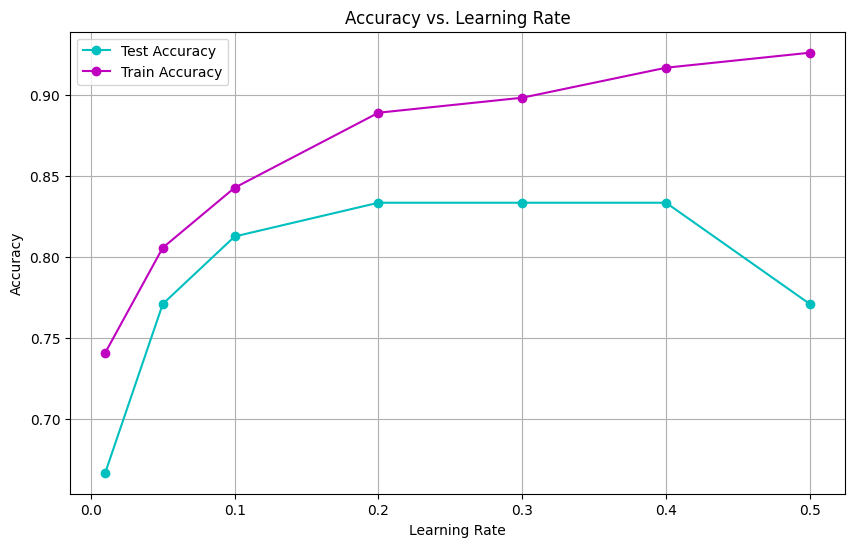

In [19]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'algorithm': ['SAMME']
}

model = AdaBoostClassifier(random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

start = time.time()

grid_search.fit(x_train, y_train)

end = time.time() - start

print(f"Best parameters found from training data: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_scores = []
accuracies = []
train_acc = []
for params in grid_search.cv_results_['params']:
    model = AdaBoostClassifier(random_state=0, **params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    test_score = f1_score(y_test, y_pred)
    test_scores.append(test_score)
    if params['algorithm'] == 'SAMME' and params['n_estimators'] == 200 :
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies.append((params['learning_rate'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc.append((params['learning_rate'], train_accuracy))

best_index = np.argmax(test_scores)
best_params = grid_search.cv_results_['params'][best_index]
best_test_score = test_scores[best_index]

print(f"Best parameters found from test data: {best_params}")
print(f"Best test score: {best_test_score}")

final_model = AdaBoostClassifier(random_state=0, **best_params)
final_model.fit(x_train, y_train)

y_pred_test = final_model.predict(x_test)
y_pred_train = final_model.predict(x_train)

print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)

print(f"Time taken for GridSearchCV: {end} seconds")
accuracies.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies]
accuracy_scores_test = [x[1] for x in accuracies]

train_acc.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc]
accuracy_scores_train = [x[1] for x in train_acc]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()

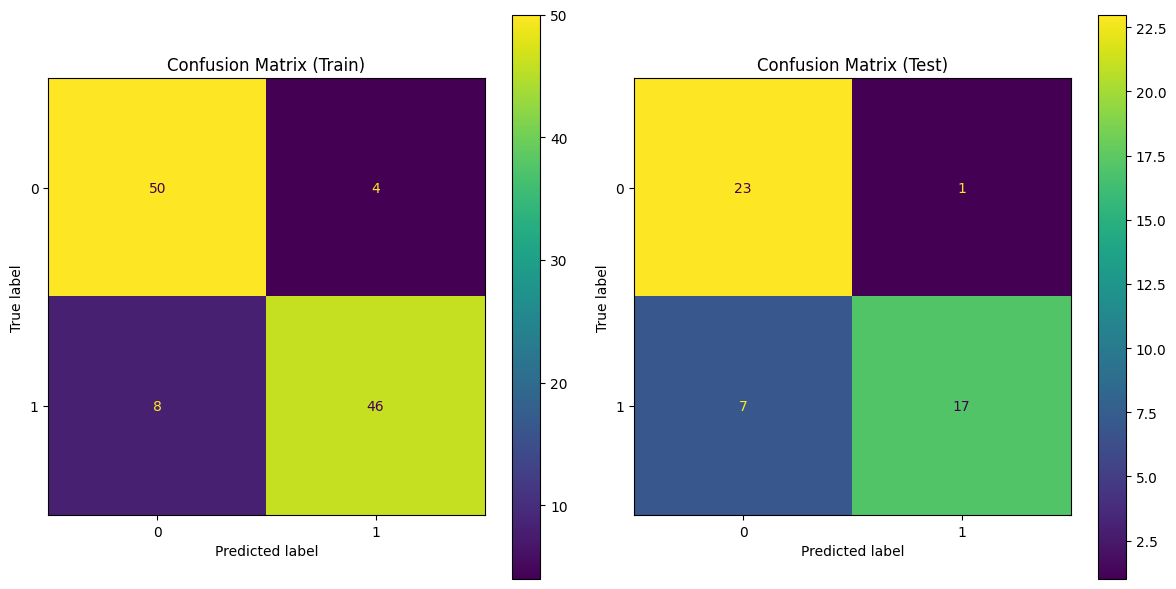

In [20]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

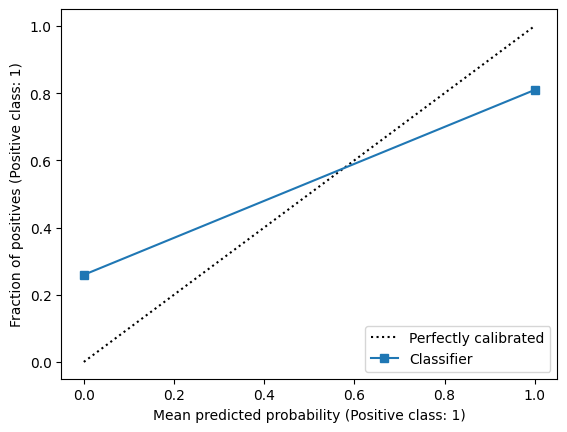

In [21]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred)
plt.show()

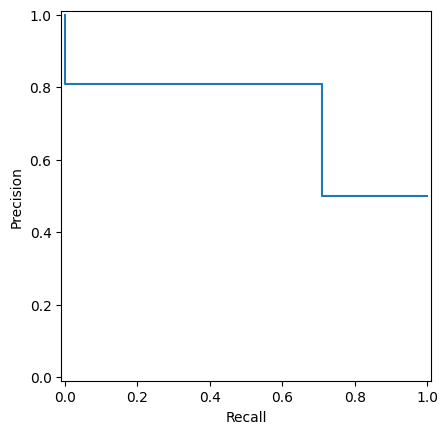

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## Random Forest 

In [23]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9 ,10, 11],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

model = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

start = time.time()

grid_search.fit(x_train, y_train)

end = time.time() - start

print(f"Best parameters found from training data: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_scores = []
accuracies = []
train_acc = []

accuracies_2 = []
train_acc_2 = []
for params in grid_search.cv_results_['params']:
    model = RandomForestClassifier(random_state=0, **params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    test_score = f1_score(y_test, y_pred)
    test_scores.append(test_score)
    if params['criterion'] == 'gini' and params['max_features'] == 'sqrt' and params['n_estimators'] == 50:
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies.append((params['max_depth'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc.append((params['max_depth'], train_accuracy))
    if params['max_depth'] == 4 and params['criterion'] == 'gini' and params['max_features'] == 'sqrt':
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies_2.append((params['n_estimators'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc_2.append((params['n_estimators'], train_accuracy))

best_index = np.argmax(test_scores)
best_params = grid_search.cv_results_['params'][best_index]
best_test_score = test_scores[best_index]

print(f"Best parameters found from test data: {best_params}")
print(f"Best test score: {best_test_score}")

final_model = RandomForestClassifier(random_state=0, **best_params)
final_model.fit(x_train, y_train)

y_pred_test = final_model.predict(x_test)
y_pred_train = final_model.predict(x_train)

print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)

print(f"Time taken for GridSearchCV: {end} seconds")



Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters found from training data: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000}
Best parameters found from test data: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}
Best test score: 0.8260869565217391
-----------------------------------------------train: 
f1 score:  0.8910891089108911
accuracy:  0.8981481481481481
precision: 0.9574468085106383
recall:  0.8333333333333334
test: 
f1 score:  0.8260869565217391
accuracy:  0.8333333333333334
precision: 0.8636363636363636
recall:  0.7916666666666666
Time taken for GridSearchCV: 115.50165891647339 seconds


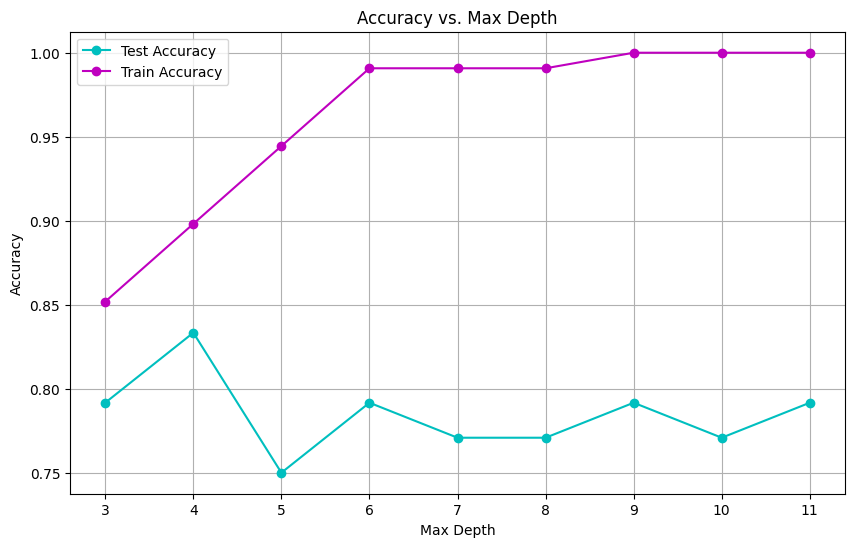

In [24]:
accuracies.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies]
accuracy_scores_test = [x[1] for x in accuracies]

train_acc.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc]
accuracy_scores_train = [x[1] for x in train_acc]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()

[(10, 0.75), (50, 0.8333333333333334), (100, 0.8333333333333334), (200, 0.7916666666666666), (300, 0.7708333333333334), (400, 0.7708333333333334), (500, 0.75), (1000, 0.75)]


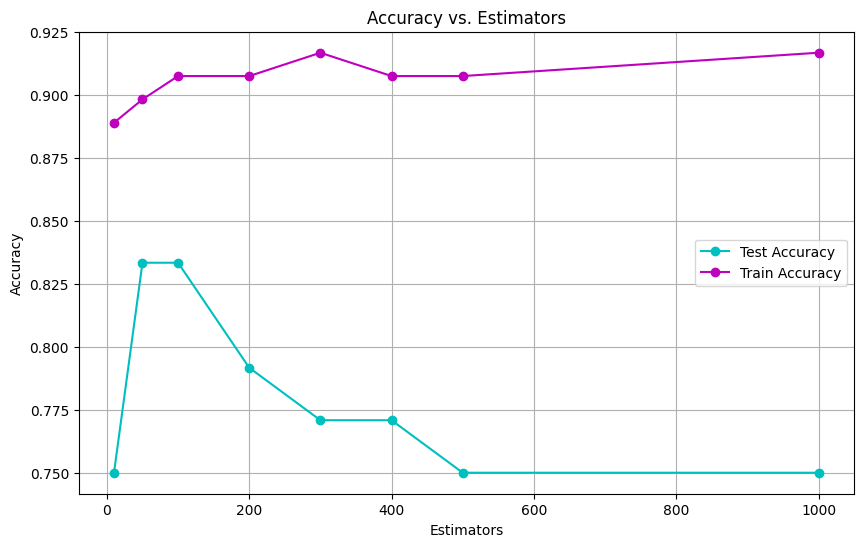

In [25]:
print(accuracies_2)

accuracies_2.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies_2]
accuracy_scores_test = [x[1] for x in accuracies_2]

train_acc_2.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc_2]
accuracy_scores_train = [x[1] for x in train_acc_2]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. Estimators')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()


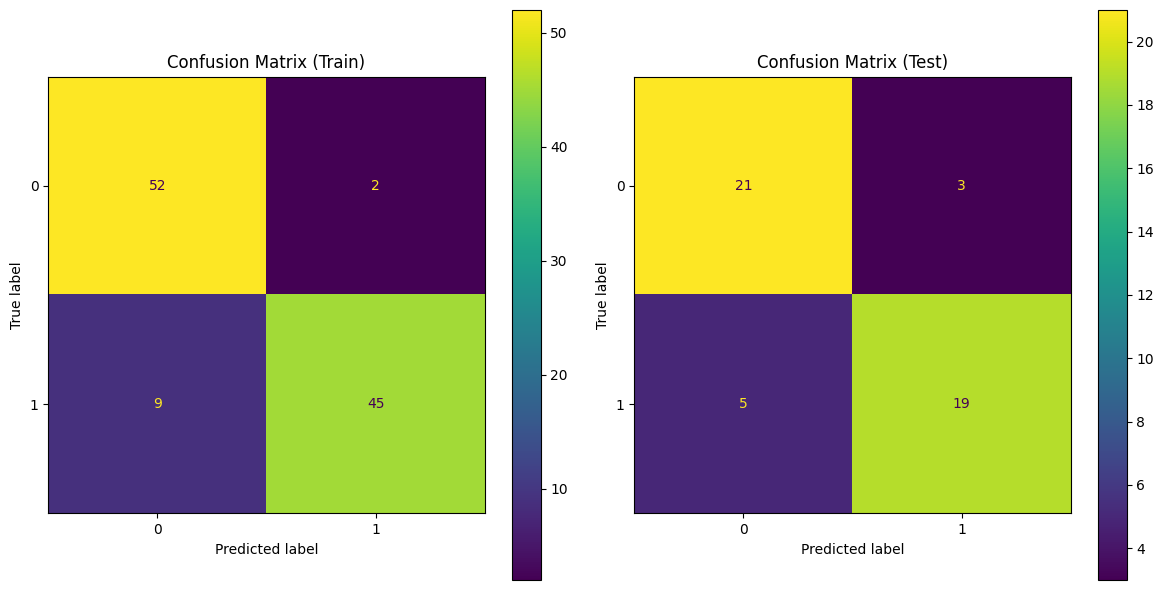

In [26]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

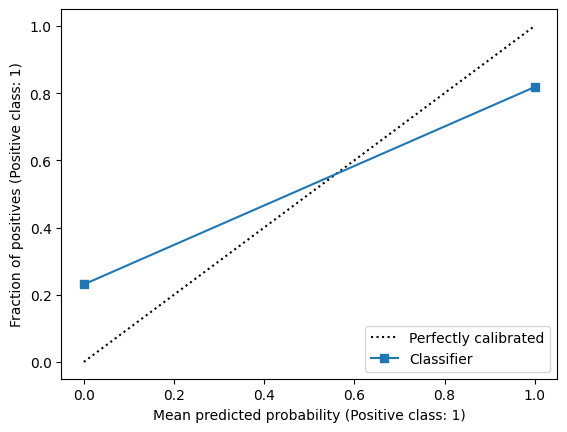

In [27]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred)
plt.show()

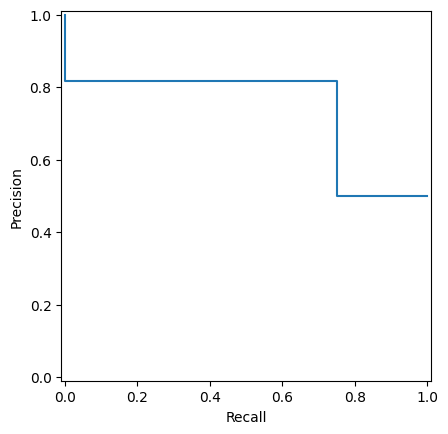

In [28]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

## XGB Classifier 

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Best parameters found from training data: {'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}


Testing parameters: 100%|██████████| 400/400 [00:16<00:00, 24.58it/s]


Best parameters found from test data: {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Best test score: 0.8181818181818182
-----------------------------------------------train: 
f1 score:  0.9908256880733946
accuracy:  0.9907407407407407
precision: 0.9818181818181818
recall:  1.0
test: 
f1 score:  0.8181818181818182
accuracy:  0.8333333333333334
precision: 0.9
recall:  0.75
Time taken for GridSearchCV: 10.292908668518066 seconds
[(0.01, 0.8518518518518519), (0.05, 0.9166666666666666), (0.1, 0.9629629629629629), (0.2, 0.9907407407407407), (0.3, 1.0)]


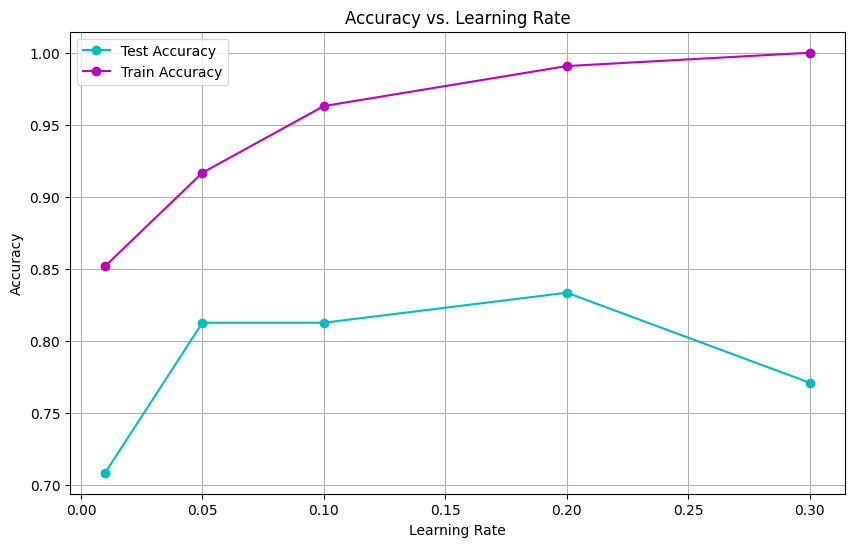

In [29]:
param_grid = {
    'max_depth': [3, 5, 6, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'gamma': [0.1, 0.2, 0.3, 0.4],
}

model = XGBClassifier(objective='binary:logistic', random_state=0)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

start = time.time()

grid_search.fit(x_train, y_train)

end = time.time() - start

print(f"Best parameters found from training data: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_scores = []
accuracies = []
train_acc = []
for params in tqdm(grid_search.cv_results_['params'], desc="Testing parameters"):
    model = XGBClassifier(objective='binary:logistic', random_state=0, **params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    test_score = f1_score(y_test, y_pred)
    test_scores.append(test_score)
    if params['n_estimators'] == 50 and params['max_depth'] == 3 and params['gamma'] == 0.1:
        accuracy =  accuracy_score(y_test, y_pred)
        accuracies.append((params['learning_rate'], accuracy))
        train_accuracy =  accuracy_score(y_train, y_pred_train)
        train_acc.append((params['learning_rate'], train_accuracy))
        
best_index = np.argmax(test_scores)
best_params = grid_search.cv_results_['params'][best_index]
best_test_score = test_scores[best_index]

print(f"Best parameters found from test data: {best_params}")
print(f"Best test score: {best_test_score}")

final_model = XGBClassifier(objective='binary:logistic', random_state=0, **best_params)
final_model.fit(x_train, y_train)

y_pred_test = final_model.predict(x_test)
y_pred_train = final_model.predict(x_train)

print("-----------------------------------------------train: ")
metrics(y_pred_train, y_train)
print("test: ")
metrics(y_pred_test, y_test)

print(f"Time taken for GridSearchCV: {end} seconds")
print(train_acc)

accuracies.sort(key=lambda x: x[0])
max_depths_test = [x[0] for x in accuracies]
accuracy_scores_test = [x[1] for x in accuracies]

train_acc.sort(key=lambda x: x[0])
max_depths_train = [x[0] for x in train_acc]
accuracy_scores_train = [x[1] for x in train_acc]

plt.figure(figsize=(10, 6))

plt.plot(max_depths_test, accuracy_scores_test, marker='o', linestyle='-', color='c', label='Test Accuracy')

plt.plot(max_depths_train, accuracy_scores_train, marker='o', linestyle='-', color='m', label='Train Accuracy')

plt.title('Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

plt.grid(True)

plt.legend()

plt.show()


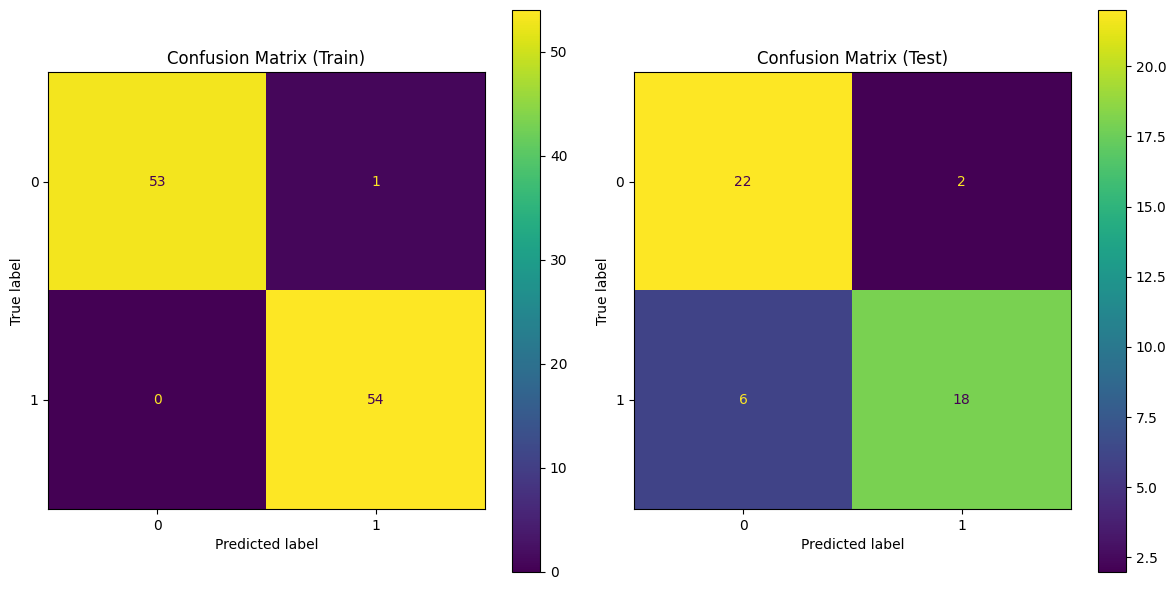

In [30]:
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_train).plot(ax=ax[0], colorbar=True)
ax[0].set_title('Confusion Matrix (Train)')

ConfusionMatrixDisplay(cm_test).plot(ax=ax[1], colorbar=True)
ax[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

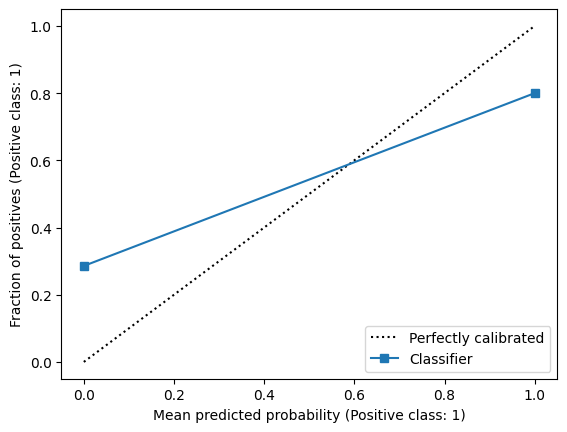

In [31]:
disp = CalibrationDisplay.from_predictions(y_test, y_pred)
plt.show()

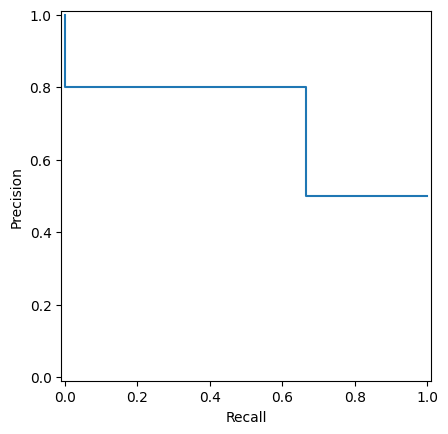

In [32]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()